In [108]:
from Binaries import *

def spd_energy_efficiency(self, dataset : str, **kwargs) -> None :
            
            warnings.simplefilter("ignore", RuntimeWarning)
            colormap = cmap.get_cmap("plasma")
            bar_kwargs = \
            {
                "fmt" : "o",
                "elinewidth" : 0.5,
                "capsize" : 3
            }
            
            e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
            annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

            energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
            theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

            miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
            hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

            # Prediction structure: []
            TP, FP, TN, FN = self.load_and_print_performance(dataset)

            # Sort predictions into bins of theta and energy
            for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

                spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
                energy_sorted = np.digitize(energy, energy_bins)
                theta_sorted = np.digitize(theta, theta_bins)

                for e, t, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
                    target[e - 1][t - 1].append(shower_plane_distance)


            if kwargs.get("draw_plot", True):
                fig, axes = plt.subplots(3,3, sharex = False, sharey = True, figsize = [50, 25])
                fig.suptitle(f"{self.name} - {dataset}", fontsize = 50)
                axes[-1][-1].axis("off"), axes[-1][-2].axis("off")
                plt.ylim(-0.05, 1.05)

            # Calculate efficiencies given sorted performances
            # axis 1 = sorted by primary particles' energy
            for e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

                if kwargs.get("draw_plot", True): 
                    ax = axes[e // 3][e % 3]
                    ax.axvline(1500, c = "k", ls = "--")
                    ax.set_xlim(0, 6000),
                    ax.plot([], [], ls = "solid", c = "k", label = "Extrapolated")
                    ax.legend(loc = "upper right", title = annotate(e))
                    if e >= 4: 
                        ax.set_xlabel("Shower plane distance / m")
                        ax.set_xticks([1e3, 2e3, 3e3, 4e3, 5e3])
                    else:
                        ax.set_xticks([])
                    if e % 3 == 0: ax.set_ylabel("Trigger efficiency")

                # axis 2 = sorted by zenith angle
                for t, (hits, misses) in enumerate(zip(hits, misses)):

                    LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", e, t)

                    c = colormap(t / (len(theta_bins) - 1))
                    all_data = hits + misses
                    n_data_in_bins = int(50 * np.sqrt(e + 1))

                    # have at least 7 bins or bins with >50 samples
                    while True:
                        n_bins = len(all_data) // n_data_in_bins
                        probabilities = np.linspace(0, 1, n_bins)
                        binning = mquantiles(all_data, prob = probabilities)
                        bin_center = 0.5 * (binning[1:] + binning[:-1])
                        n_all, _ = np.histogram(all_data, bins = binning)

                        if len(n_all) <= 7: 
                            n_data_in_bins -= 10
                            if n_data_in_bins <= 50: break
                        else: break

                    x, _ = np.histogram(hits, bins = binning)
                    o, _ = np.histogram(misses, bins = binning)
                    efficiency = x / (x + o) * LDF(bin_center)
                    efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
                    efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

                    # perform fit with x_err and y_err
                    try:
                        if kwargs.get("perform_fit", True):

                            try:
                                # # lateral_trigger_probability(x : np.ndarray, efficiency : float, prob_50, scale : float, C : float)
                                # popt, pcov = curve_fit(lateral_trigger_probability, bin_center, efficiency, 
                                #                                         p0 = [efficiency[0], bin_center[np.argmin(abs(efficiency - 50))], LDF_scale, 2 * LDF_scale],
                                #                                         bounds = ([0, 0, 0, 0], [1, np.inf, 1, 0.5]),
                                #                                         sigma = efficiency_err,
                                #                                         absolute_sigma = True,
                                #                                         maxfev = 10000)

                                # When running in compatibility mode (i.e. using lateral_distribution_function under the hood)
                                # lateral_distribution_function(x : np.ndarray, efficiency : float, prob_50 : float, scale : float)
                                popt, pcov = curve_fit(new_lateral_trigger_probability, bin_center, efficiency, 
                                                                        p0 = [1, LDF_prob_50, 1/LDF_scale],
                                                                        bounds = ([1, 0, 0], [2, 1000, np.inf]),
                                                                        sigma = efficiency_err,
                                                                        absolute_sigma = True,
                                                                        maxfev = 10000)

                                # # write fit parameters to disk
                                # file_name = f"{e_labels[e].replace('$','')}_{e_labels[e+1].replace('$','')}__{int(theta_bins[t])}_{int(theta_bins[t+1])}.csv"

                                # if hasattr(self, "epochs"):
                                #     fit_dir = f"/cr/data01/filip/models/{self.name}/model_{self.epochs}/ROC_curve/{dataset}/FITPARAM/"
                                # else: fit_dir = f"/cr/data01/filip/models/{self.name}/ROC_curve/{dataset}/FITPARAM/"
                                
                                # try: os.mkdir(fit_dir)
                                # except FileExistsError: pass

                                # with open(fit_dir + file_name, "w") as fit_parameters:
                                #     np.savetxt(fit_parameters, popt)


                                if kwargs.get("draw_plot", True):

                                    X = np.geomspace(1e-3, 6000, 1000)

                                    efficiency_fit = lateral_trigger_probability(X, *popt)
                                    efficiency_fit_error = lateral_trigger_probability_error(X, pcov, *popt)
                                    bottom = np.clip(efficiency_fit - efficiency_fit_error, 0, 1)
                                    top = np.clip(efficiency_fit + efficiency_fit_error, 0, 1)
                                
                                    ax.plot(X, efficiency_fit, color = c)
                                    ax.fill_between(X, bottom, top, color = c, alpha = 0.1)
                            
                            except IndexError: pass
                    
                    except ValueError: pass

                    if kwargs.get("draw_plot", True):
                        upper = np.clip(efficiency + efficiency_err, 0, 1)
                        lower = np.clip(efficiency - efficiency_err, 0, 1)

                        ax.errorbar(bin_center, efficiency, yerr = [efficiency - lower, upper - efficiency], color = c, **bar_kwargs)

            norm = BoundaryNorm(theta_bins, colormap.N)
            ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
            cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
            cbar.set_ticks(theta_bins)
            cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

            plt.subplots_adjust(hspace = 0.04, wspace = 0)

            warnings.simplefilter("default", RuntimeWarning)

In [111]:
def new_lateral_trigger_probability(x : np.ndarray, efficiency : float, prob_50 : float, scale : float) -> np.ndarray : 
     return np.clip(efficiency * (1 - 1 / (1 + np.exp((x - prob_50) / scale))), 0, 1)

def new_lateral_trigger_probability_error(x : np.ndarray, *args) -> np.ndarray : 
    return np.zeros_like(x)

HardwareClassifier                            compatibility_corrected_all_ph...     89144       0       0  156908 -> ACC =  36.23%


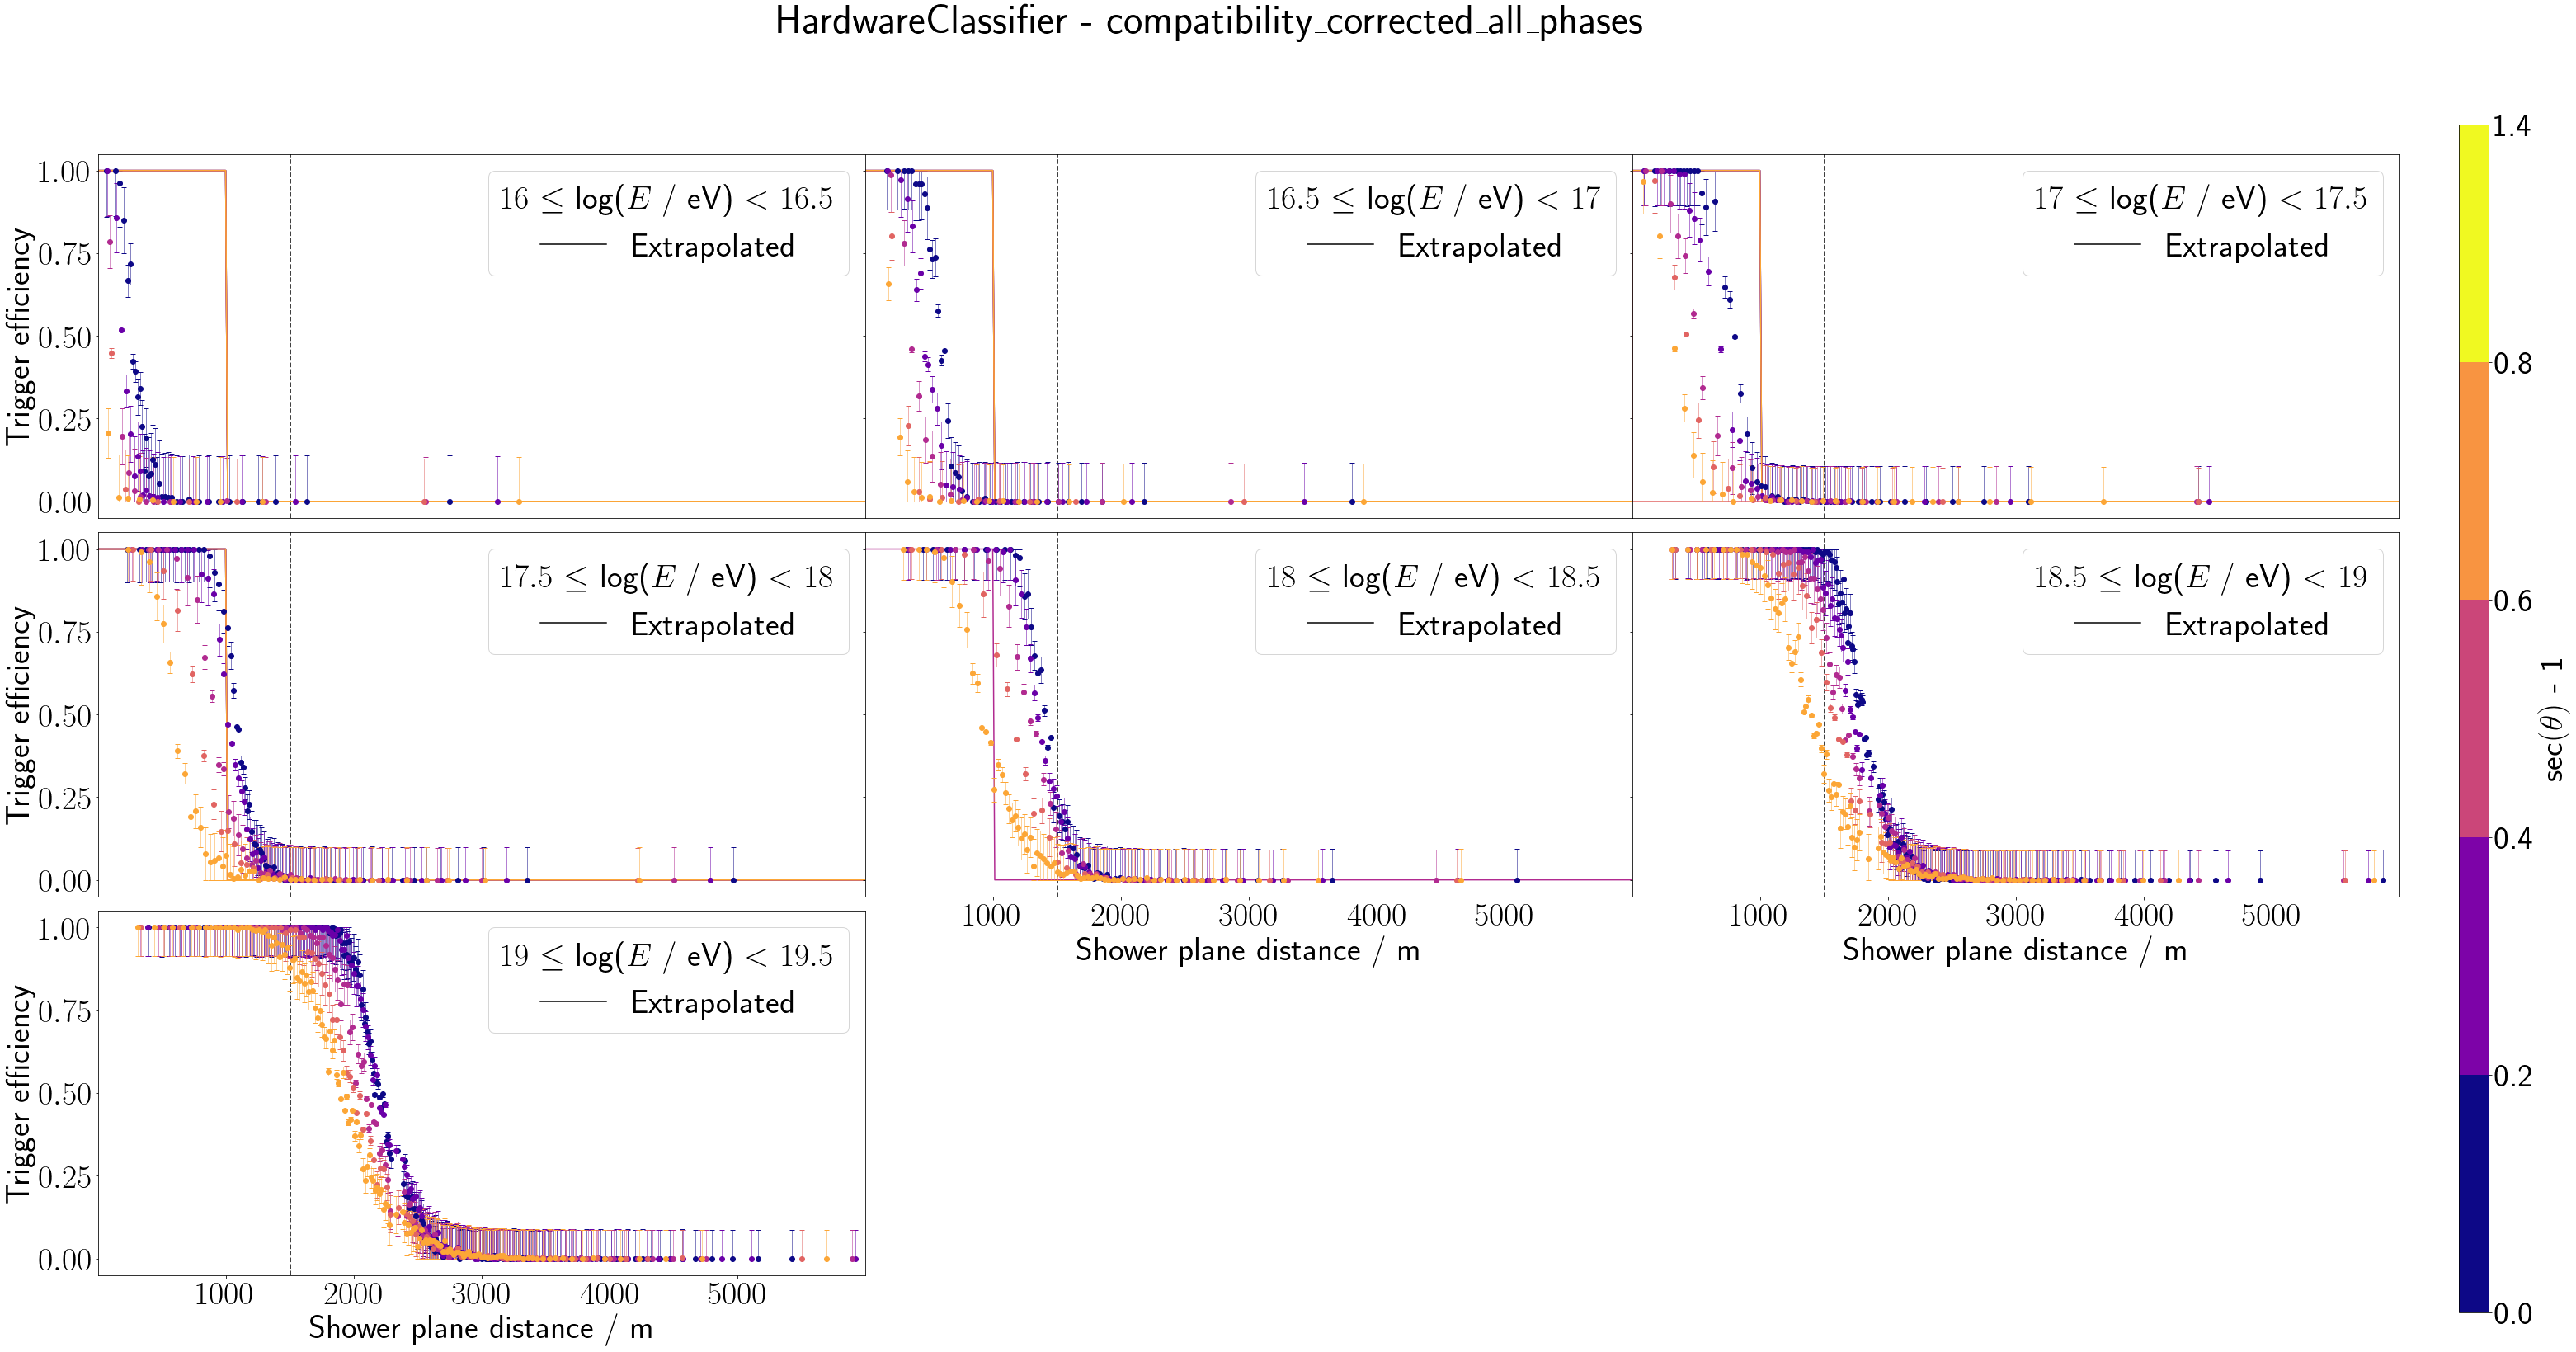

In [112]:
TestClassifier = HardwareClassifier()
spd_energy_efficiency(TestClassifier, "compatibility_corrected_all_phases")